# Movie Recommender Systems

## Author: Arash Shamseddini

In this script, I will build a variety of movie recommender systems using the [MovieLens dataset](https://www.kaggle.com/datasets/prajitdatta/movielens-100k-dataset). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it.

In a nutshell, a recommender system recommends a particular product or service to users. We can see numeroous examples of these systems in the applications we use on a daily basis for example to shop online or watch movies.

This resourse here elaborates on what Recommender Systems and the Machine Learning behind them are and you can refer to it if you are new to the concept.

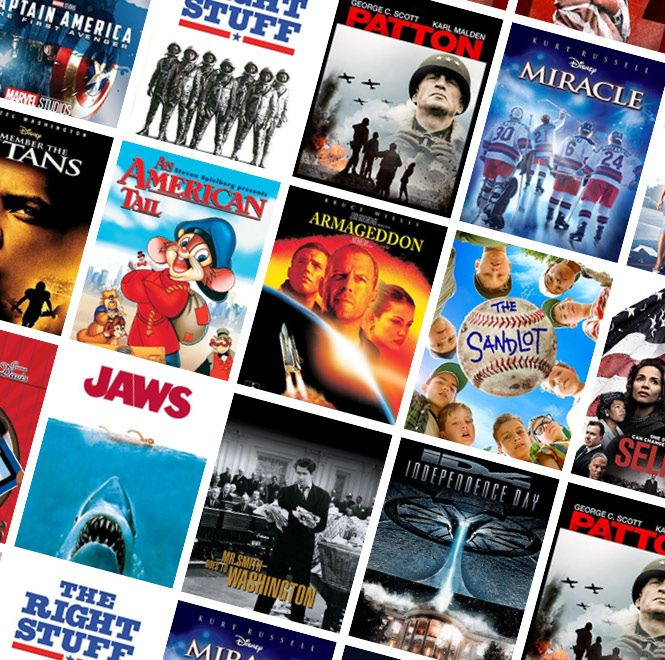

In [1]:
from IPython import display
# Image 1
display.Image("images/movies.jpg")

In [2]:
# Necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.decomposition import TruncatedSVD
import surprise
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from sklearn.linear_model import Ridge

#### 1- Data set

Let's read the data in. The data set exist in the `data/ml-100k/` folder of this repo.

In [3]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv("data/ml-100k/u.data",
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


#### 2- Notations

Before going any further, let's set some ground rules with defining some notations which will be used in this script.

**Constants**:

 - $N$: Number of users, indexed by $n$
 - $M$: Number of movies, indexed by $m$
 - $\mathcal{R}$: Set of indices $(n,m)$ where I have ratings in the utility matrix $Y$
 - $k$: Number of latent dimensions I use in collaborative filtering
 
**The data**:

 - $Y$: Utility matrix containing ratings, with a lot of missing entries
 - $Z$: A matrix whose rows $z_m$ represent the features for movie $m$ (size $M\times d$).
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 

#### 3- EDA

To get a better inderstading of the data, I have defined a helper function as below:

In [4]:
# Initializing N & M
N = None
M = None

# Helper function to review the data
def get_stats(ratings, item_key="movie_id", user_key="user_id"):
    print("Number of ratings:", len(ratings))
    print("Average rating:  %0.3f" % (np.mean(ratings["rating"])))
    N = len(np.unique(ratings[user_key]))
    M = len(np.unique(ratings[item_key]))
    print("Number of users (N): %d" % N)
    print("Number of items (M): %d" % M)
    print("Fraction non-nan ratings: %0.3f" % (len(ratings) / (N * M)))
    return N, M

N, M = get_stats(ratings)

# Printing N & M
print("Number of users (N): %d" % N)
print("Number of items (M): %d" % M)

Number of ratings: 100000
Average rating:  3.530
Number of users (N): 943
Number of items (M): 1682
Fraction non-nan ratings: 0.063
Number of users (N): 943
Number of items (M): 1682


So, the shape of utility matrix $Y$ is (**943**, **1682**).

Now lets see what the fraction of non missing ratings in the utility matrix $Y$ is.

In [5]:
# Priniting the fraction of non missing ratings in the utility matrix 𝑌
print("The fraction of non missing ratings in the utility matrix 𝑌: %0.3f" % (len(ratings) / (N * M)))
print("where")
print("Number of ratings:", len(ratings))

The fraction of non missing ratings in the utility matrix 𝑌: 0.063
where
Number of ratings: 100000


and the verage number of ratings per user and per movie:

In [6]:
# Priniting average number of ratings per user and movie
print("The average number of ratings per user: %0.0f" % (len(ratings) / N))
print("The average number of ratings per movie: %0.0f" % (len(ratings) / M))

The average number of ratings per user: 106
The average number of ratings per movie: 59


#### 4- Splitting the Data

Now that I have a better understanding of what the data looks like, let's split the data:

In [7]:
# Splitting the ratings data
ratings = ratings.drop(columns="timestamp")
X = ratings.copy()
y = ratings["user_id"]
X_train, X_valid, y_train, y_valid=train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Now that I have both the `train` and `validation` set, let's create utility matrices for `train` and `validation` sets.

I will define a helper function to help me create the utility matrix off of these two sets.

In [8]:
# I'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

# Defining create_Y_from_ratings() function 
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

# Creating utility matrices for train and validation sets
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

The train matrix (`train_mat`) is of the shape $(N×M)$ but it only has `X_train` ratings (i.e. only ratings from the train set). The validation matrix (`valid_mat`) is of the shape $(N×M)$ too but it only has `X_valid` ratings (i.e. only ratings from the valid set).

As expected, the train matrix is used for training while the validation matrix is used for evaluating the model.

#### 5- Evaluation

Since, the goal here is to build a number of models, I will be evaluating them using the helper functions below.

In [9]:
# Defining error() function 
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))

# Defining evaluate() function 
def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    """
    Prints the train and validation RMSEs.
    """
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))

But what am I comparing to evaluate recommender systems?

Here I are comparing the **true** ratings of the items given by users with the **predicted** ratings. In other words we are calculating the **Root Mean Squared Error (RMSE)** between the **true** and the **predicted** ratings. In recommender systems our goal is predicting missing entries in the utility matrix and to find the items a user is interested in.

But the truth is that this evaluation method is not precisely capturing what I want to assess in recommender systems. In fact, real evaluation of recommender systems can be tricky because there is no ground truth.

#### 6- Modeling

##### 6-1 Baselines

But firts, let's develop some baseline models that will eventually help us with better evaluation of our models.

##### 6-1-1 Global Average Rating baseline

In [10]:
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")

Global average train RMSE: 1.12
Global average valid RMSE: 1.13


##### 6-1-2 Per-user Average baseline

In [11]:
avg_n = np.nanmean(train_mat, axis=1)
avg_n[np.isnan(avg_n)] = avg
pred_n = np.tile(avg_n[:, None], (1, M))
evaluate(pred_n, train_mat, valid_mat, model_name="Per-user average")

Per-user average train RMSE: 1.03
Per-user average valid RMSE: 1.04


##### 6-1-3 Per-movie Average baseline

In [12]:
avg_m = np.nanmean(train_mat, axis=0)
avg_m[np.isnan(avg_m)] = avg
pred_m = np.tile(avg_m[None, :], (N, 1))
evaluate(pred_m, train_mat, valid_mat, model_name="Per_movie average")

Per_movie average train RMSE: 1.00
Per_movie average valid RMSE: 1.03


##### 6-1-4 Average of Per-user and Per-movie Average baselines

In [13]:
avg_m_n = (avg_m[None, :] + avg_n[:, None]) / 2
pred_m_n = np.zeros(train_mat.shape) + avg_m_n
evaluate(pred_m_n, train_mat, valid_mat, model_name="Per_movie and per_user average")

Per_movie and per_user average train RMSE: 0.96
Per_movie and per_user average valid RMSE: 0.99


Based on the **RMSE** results from different baselines, the **average of per-movie and per-user averages** baseline is perfroming better than other baselines.

##### 6-2 Collaborative Filtering

A popular approach to recommender systems is `Collaborative Filtering` is popular approach to recommender systems where a method like **SVD** can be employed to fill in the missing entries of the utility matrix.

##### 6-2-1 SVD with missing values represented with zeros

Here, I'll use `TruncatedSVD` and reconstructions to fill in missing entries of the utility matrix.

`TruncatedSVD` in nature cannot work with missing values, therefore a workaround would be replacing all missing entries with zeros before passing the train utility matrix to `TruncatedSVD`.

To generalize, I will try a few reasonable values for the hyperparameter `n_components`.

In [14]:
# Applying Truncated SVD 
de_meaned_mat = train_mat - avg
de_meaned_mat = np.nan_to_num(de_meaned_mat)

# Defining n_components_list
n_components_list = [5, 10, 15, 20, 50]
for n in n_components_list:
    tsvd = TruncatedSVD(n_components=n)
    Z = tsvd.fit_transform(de_meaned_mat)
    W = tsvd.components_
    pred_tsvd = (Z @ W) + avg
    print("\nn_components: ", n)
    evaluate(pred_tsvd, train_mat, valid_mat, model_name="Truncated SVD")


n_components:  5
Truncated SVD train RMSE: 1.01
Truncated SVD valid RMSE: 1.06

n_components:  10
Truncated SVD train RMSE: 0.97
Truncated SVD valid RMSE: 1.05

n_components:  15
Truncated SVD train RMSE: 0.93
Truncated SVD valid RMSE: 1.04

n_components:  20
Truncated SVD train RMSE: 0.91
Truncated SVD valid RMSE: 1.05

n_components:  50
Truncated SVD train RMSE: 0.78
Truncated SVD valid RMSE: 1.07


It looks like that the RMSE results from `Truncated SVD` are not better compared to baselines. The results are in fact close to those of baseline models.

The main consequence of replacing missing values with zeros here before passing the train utility matrix to `TruncatedSVD` is that by assigning **0** we are in fact building a model that tends to predict zero in case it runs into misssing values. This is in a sense, like **"voting 0"** for a movie (not liking a movie) compared to **"not voting at all"**, which is quite different. In other words, we are influencing the ratings by setting NaNs to 0 while the true ratings can be higher or lower than **0**.

##### 6-2-2 SVD with proper handling of missing values

For this, I will use the `surprise` package which has implementation of SVD for recommender systems with proper handling os missing values. 

In [15]:
reader = Reader()
data = Dataset.load_from_df(ratings, reader)
data
k = 10
algo = SVD(n_factors=k, random_state=42)
cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9282  0.9413  0.9374  0.9360  0.9364  0.9359  0.0043  
MAE (testset)     0.7333  0.7441  0.7387  0.7398  0.7378  0.7387  0.0035  
Fit time          2.23    2.77    2.61    3.84    2.25    2.74    0.59    
Test time         0.13    0.25    0.22    0.12    0.25    0.20    0.06    


{'test_rmse': array([0.92824749, 0.94133663, 0.93739469, 0.9360186 , 0.93639384]),
 'test_mae': array([0.73328027, 0.74411212, 0.73870336, 0.73981187, 0.73776407]),
 'fit_time': (2.2322986125946045,
  2.7684037685394287,
  2.6053855419158936,
  3.840991735458374,
  2.251861095428467),
 'test_time': (0.13006925582885742,
  0.2478957176208496,
  0.22362256050109863,
  0.12189841270446777,
  0.2538299560546875)}

It seems that the mean **RMSE** (test set) is **0.94** (rounded to two decimals).

Comparing these results with the previous results I can see that there is a notable improvement in **RMSE** with respect to baseline models and also compared to `Truncated SVD`.

The main difference between this approach and the `Truncated SVD` is the way the missing values are handled by the SVD algorithm from `suprise` package in which SVD implementation only considers available ratings in the loss function, which makes a whole lot of difference with how these values were handled before by assigning 0 value to them in `Truncated SVD`.

##### 6-3 Content-based Recommenders

Here, I'll use supervised models to fill in the entries in the utility matrix.

In `Collaborative Filtering` we only use the utility matrix $Y$, but can we use information available for movies or users along with the ratings information? 

That's where `Contenet-based` Recommenders come into play.

Below, I 'll load movie genre features from `ml-100k/u.item` and store them in a variable called `G`.

In [16]:
cols = [
    "movie_id",
    "movie title",
    "release date",
    "video release date",
    "IMDb URL",
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]

movies_data = pd.read_csv(
    os.path.join("data", "ml-100k", "u.item"),
    sep="|",
    names=cols,
    encoding="latin-1",
)
movies_data.head()

,movie_id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
genres = [
    "Action",
    "Adventure",
    "Animation",
    "Children",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film-Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci-Fi",
    "Thriller",
    "War",
    "Western",
]
movie_genres = movies_data[genres]
movie_genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [18]:
G = movie_genres.to_numpy()
G.shape

(1682, 18)

##### 6-3-1 Per-user Regression Using Movie Features

In this section, I will train per-user regression models using movie features. The helper function `get_X_y_per_user` defined below creates `X` and `y` for each user with movie genre features.

In [19]:
# Defining get_X_y_per_user() function
def get_X_y_per_user(ratings_df, d=G.shape[1]):
    """
    Returns X and y for each user.

    Parameters:
    ----------
    ratings_df : pandas.DataFrame
         ratings data as a dataframe

    d : int
        number of item features

    Return:
    ----------
        dictionaries containing X and y for all users
    """
    lr_y = defaultdict(list)
    lr_X = defaultdict(list)

    for index, val in ratings_df.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        lr_X[n].append(G[m])
        lr_y[n].append(val["rating"])

    for n in lr_X:
        lr_X[n] = np.array(lr_X[n])
        lr_y[n] = np.array(lr_y[n])

    return lr_X, lr_y

I 'll now call abover helper function on `train` and `validation` ratings to get `X` and `y` per user in these sets.

In [20]:
# Calling get_X_y_per_user() on train and validation ratings
X_train_usr, y_train_usr = get_X_y_per_user(X_train, d=G.shape[1])
X_valid_usr, y_valid_usr = get_X_y_per_user(X_valid, d=G.shape[1])

Obviously users **do not have** the same number of rows since the number of movies different users have actually rated is not the same for all users, i.e., each user has rated a certain number of movies.

Now, I 'll train `Ridge()`, as a regressor, for each user, to predict missing ratings in the utility matrix, to streamline this, I will define below helper functions. 

In [21]:
# Defining train_for_usr() function
def train_for_usr(user_name, model=Ridge()):
    X = X_train_usr[user_mapper[user_name]]
    y = y_train_usr[user_mapper[user_name]]
    model.fit(X, y)
    return model

# Defining predict_for_user() function
def predict_for_usr(model, movie_names):
    feat_vecs = movie_genres.loc[movie_names].values
    preds = model.predict(feat_vecs)
    return preds

In [22]:
# Predicting missing ratings in the utility matrix
user_list = np.unique(ratings[user_key])
movie_list = list(np.unique(ratings[item_key])-1)
result = list()

for user in user_list:
    model = train_for_usr(user)
    result.append(predict_for_usr(model, movie_list))

In [23]:
# Reporting train and validation RMSE
evaluate(result, train_mat, valid_mat, model_name="Content-based Filtering")

Content-based Filtering train RMSE: 0.91
Content-based Filtering valid RMSE: 1.05


It is obvious that above validation (**RMSE = 1.05**) is somewhat better than the RMSE from `Collaborative Filtering` with `TruncatedSVD`. However, compared to `Collaborative Filtering` with **SVD** from `suprise` package (**RMSE = 0.94**), we can see that `Content-based Filtering` performs poorer. 

This can be potentially due to the fact that in `Collaborative Filtering` we do not have access to any item features but in `Content-based Filtering` we have some carefully extracted item features along with the utility matrix.

##### This is the end of the notebook.